# Setup

Get required libraries

In [20]:
!pip install wikipedia

import json
import logging
import os
import urllib
import sys

import numpy as np
import pandas as pd
import requests
import wikipedia as wp

try:
    from google.colab import drive, files
    MOUNT = '/content/drive/'
    drive.mount(MOUNT)
    COLAB = True
    GDRIVE_DIR = os.path.join(MOUNT, "My Drive/results")
except ImportError:
    COLAB = False
    IMG_DIR= "/app/notebook/results"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Set up the logging, report to STDOUT

In [0]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger('museums')

# Fetch museum data

Get the data

In [0]:
# Get the html source
html = wp.page("List of most visited museums").html().encode("UTF-8")

# Convert to Pandas
museum_df = pd.read_html(html)[0]

Quick check

In [23]:
museum_df

,Name,"Country flag, city",Visitors per year,Year reported
0,Louvre,Paris,10200000,2018[12]
1,National Museum of China,Beijing,8610092,2018[13]
2,Metropolitan Museum of Art[b],New York City,6953927,2018[13]
3,Vatican Museums,Vatican City,6756186,2018[13]
4,National Air and Space Museum,"Washington, D.C.",6200000,2018[12]
...,...,...,...,...
57,Van Gogh Museum,Amsterdam,2161160,2018[13]
58,Tretyakov Gallery,Moscow,2148538,2018[13]
59,Shanghai Museum,Shanghai,2111730,2018[13]
60,Auschwitz-Birkenau State Museum,OÅwiÄcim,2100000,2018[12]


## Data cleaning
~~1) Remove unnecessary multi-level index~~ *Fixed in Pandas update*

~~2) Remove "Unnamed" column~~ *Fixed in Pandas update*

5) Rename columns

4) Remove superscript notes in `Museum` and `Year` columns

5) Remove trailing regions in City, i.e. `Washington, D.C.` becomes `Washington`



In [0]:
# museum_df.columns = museum_df.columns.droplevel(0)

In [0]:
# museum_df = museum_df.drop("Unnamed: 4_level_1", axis=1)

In [0]:
museum_df = museum_df.rename(columns={
    "Name": "Museum",
    "Country flag, city": "City",
    "Visitors per year": "Visitors",
    "Year reported": "Year",   
})

In [0]:
museum_df["Year"].replace(
    inplace=True,
    regex=True,
    to_replace=r'\[.*\]',
    value=r'',
)
museum_df.Year.fillna(value=pd.np.nan, inplace=True)
museum_df["Year"] = museum_df["Year"].astype(int)

In [0]:
museum_df["Museum"].replace(
    inplace=True,
    regex=True,
    to_replace=r'\[\S\]',
    value=r''
)

In [0]:
museum_df['City'].replace(
    inplace=True,
    regex=True,
    to_replace=r'\,.*',
    value=r''
)

# Dirty fix for Auschwitz
museum_df["City"] = museum_df["City"].astype("str").str.replace("OÅ\x9bwiÄ\x99cim", "Oswiecim")

Eye-ball the results

In [30]:
museum_df

,Museum,City,Visitors,Year
0,Louvre,Paris,10200000,2018
1,National Museum of China,Beijing,8610092,2018
2,Metropolitan Museum of Art,New York City,6953927,2018
3,Vatican Museums,Vatican City,6756186,2018
4,National Air and Space Museum,Washington,6200000,2018
...,...,...,...,...
57,Van Gogh Museum,Amsterdam,2161160,2018
58,Tretyakov Gallery,Moscow,2148538,2018
59,Shanghai Museum,Shanghai,2111730,2018
60,Auschwitz-Birkenau State Museum,Oswiecim,2100000,2018


## Save result

In [0]:
from datetime import date
now = date.today()
today = now.strftime("%Y%m%d")

In [0]:
if COLAB:
    museum_df.to_csv(
        os.path.join(
            GDRIVE_DIR,
            f"museums_{today}.csv"
        )
    )
else:
    museum_df.to_csv(
        os.path.join(
            IMG_DIR,
            f"museums_{today}.csv"
        )
    )

# City populations

As some of the museums are listed in cities with small residential populations (notably Vatican City and Oswiecim (a small Polish village)), we will not be able to just pull a list of city populations and join straight away on the database.

Instead, we'll need to setup a loop for each city with a lookup to Wikipedia for that city. Then parse the page for the population from the metadata.

**Assumption:** This method will note be able to necessarily exactly correlate the date of population count with the year of museum.

## Create fetch city info function
Create a function to fetch city metadata

In [0]:
def get_city_information_from_opendata(city : str, country : str='') -> dict:
    """Get a city's information from the OpenDataSoft API.

    Notes
    -----
    Function returns only the largest matching city.
    i.e. ``city="London"`` returns London, UK not London, ON, Canada
    
    Parameters
    ----------
    city : str
    country : str
        Optional, 2 letter country code for further filtering

    Returns
    -------
    dict

    """
    api_url = "https://public.opendatasoft.com/api/records/1.0/search"

    parameters = {
        "dataset": "worldcitiespop",
        "q": city,
        "sort": "population",
        "facet": "country",
    }

    if country:
        parameters.update({
            "refine.country": country,
        })

    response = requests.get(
        url=api_url,
        params=parameters,
        headers={'Content-type': 'text/plain; charset=utf-8'}
    )

    raw_response = json.loads(response.content)

    if raw_response["records"]:
        city_info = raw_response["records"][0]["fields"]
        city_info["timestamp"] = raw_response["records"][0]["record_timestamp"]
    else:
        city_info = dict()

    return city_info

Create a new DataFrame, using the city dataframe as the basis

In [0]:
cities_df = museum_df["City"].copy().to_frame()

Create new columns for `Population` and `Year`

In [0]:
cities_df["Population"] = np.nan
cities_df["Timestamp"] = ''

## Fetch data

For each city fetch the metadata

**Notes**

1) This is slow as we're hiting the API for each city

2) This is slow as we're going step-wise through the dataframe. We should use `pd.DataFrame[column].apply()` to have the transformation applied in C at the column level.

In [0]:
for idx, row in cities_df.iterrows():
    city = row["City"].encode('ascii', 'ignore')

    city_meta = get_city_information_from_opendata(city)

    cities_df.at[idx, "Population"] = city_meta.get("population", np.nan)
    cities_df.at[idx, "Timestamp"] = city_meta.get("timestamp", np.nan)



In [37]:
cities_df["Year"] = pd.to_datetime(cities_df["Timestamp"]).apply(lambda x: x.strftime('%Y'))

cities_df

,City,Population,Timestamp,Year
0,Paris,2110694.0,2018-01-08T11:47:45.345000+00:00,2018
1,Beijing,NaN,2018-01-08T11:47:45.345000+00:00,2018
2,New York City,NaN,NaN,NaT
3,Vatican City,NaN,NaN,NaT
4,Washington,552433.0,2018-01-08T11:47:45.345000+00:00,2018
...,...,...,...,...
57,Amsterdam,745811.0,2018-01-08T11:47:45.345000+00:00,2018
58,Moscow,10381288.0,2018-01-08T11:47:45.345000+00:00,2018
59,Shanghai,14608512.0,2018-01-08T11:47:45.345000+00:00,2018
60,Oswiecim,41143.0,2018-01-08T11:47:45.345000+00:00,2018


## Save result
As our list is small for this example, let's just quickly use SQLite as a PoC, before we'd scale up to Postgres.

In [0]:
if COLAB:
    cities_df.to_csv(
        os.path.join(
            GDRIVE_DIR,
            f"city_population_{today}.csv"
        )
    )
else:
    cities_df.to_csv(
        os.path.join(
            IMG_DIR,
            f"city_population_{today}.csv"
        )
    )


# Database setup

As our list is small for this example, let's just quickly use SQLite as a PoC, before we'd scale up to Postgres.

## Create a database

In [0]:
import sqlite3
from sqlite3 import Error
 
 
def create_connection(db_file : str) -> sqlite3.connect:
    """Create a database connection to a SQLite database."""
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        logger.info(sqlite3.version)
    except Error as e:
        logger.error(e)

    return conn

In [40]:
db_url = "museum.db"

# Remove any previous runs
try:
    os.remove(db_url)
except FileNotFoundError:
    logger.warning("No previous database found, creating one now.")
finally:
    create_connection(db_url)

INFO:museums:2.6.0


### Create tables in database

In [0]:
def exec_sql(conn : sqlite3.connect, sql : str):
    """Safely attempt an sql statement.

    Parameters
    ----------
    conn: sqlite3.connect
      Connection object
    sql: str
      a SQL statement
      
    """
    try:
        c = conn.cursor()
        c.execute(sql)
    except Error as e:
        logger.warning(e)

In [0]:
cities_tbl_sql = """
CREATE TABLE IF NOT EXISTS cities (
    id integer PRIMARY KEY AUTOINCREMENT,
    city text NOT NULL
);
"""

population_tbl_sql = """
CREATE TABLE IF NOT EXISTS population (
    id integer PRIMARY KEY AUTOINCREMENT,
    city_id integer NOT NULL,
    population integer NOT NULL,
    year integer NOT NULL,
    FOREIGN KEY (city_id) REFERENCES cities (id)
);
"""

museums_tbl_sql = """
CREATE TABLE IF NOT EXISTS museums (
    id integer PRIMARY KEY AUTOINCREMENT,
    name text NOT NULL,
    city_id integer NOT NULL,
    FOREIGN KEY (city_id) REFERENCES cities (id)
);
"""

visitors_tbl_sql = """
CREATE TABLE IF NOT EXISTS visitors (
    id integer PRIMARY KEY AUTOINCREMENT,
    museum_id integer NOT NULL,
    visitors integer,
    year integer,
    FOREIGN KEY (museum_id) REFERENCES museums (id)
);
"""

In [43]:
conn = create_connection(db_url)

if conn:
    exec_sql(conn, "DROP TABLE IF EXISTS cities;")
    exec_sql(conn, "DROP TABLE IF EXISTS population;")
    exec_sql(conn, "DROP TABLE IF EXISTS museums;")
    exec_sql(conn, "DROP TABLE IF EXISTS visitors;")
    exec_sql(conn, cities_tbl_sql)
    exec_sql(conn, population_tbl_sql)
    exec_sql(conn, museums_tbl_sql)
    exec_sql(conn, visitors_tbl_sql)

else:
    logger.error("Error - Lost the database connection!")

INFO:museums:2.6.0


## Insert the data

#### Functions
Create a generic execute against the database function

In [0]:
def add_to_db(conn : sqlite3.connect, sql : str) -> int:
    """Insert a record to the database.

    Parameters
    ----------
    conn : sqlite3.connect
        Connection object
    sql : str

    Returns
    -------
    int
        record id
    
    """
    cur = conn.cursor()

    try:
        cur.execute(sql)
        new_id = cur.lastrowid
    except:
        new_id = 0

    return new_id

Create functions for inserting to each table

In [0]:
def create_city(conn : sqlite3.connect, city : str) -> int:
    """Insert a city df record into the cities tbl.

    Parameters
    ----------
    conn : sqlite3.connect
        Connection object
    city : str

    Returns
    -------
    int
        record id

    """
    sql = f"""
    INSERT INTO cities (
        city
    )
    VALUES(
        "{city}"
    );
    """
    new_id = add_to_db(conn, sql)

    return new_id

In [0]:
def create_population(
    conn : sqlite3.connect, 
    city : str, 
    population : int,
    year : int) -> int:
    """Insert a population record for a city into the populations tbl.

    Parameters
    ----------
    conn : sqlite3.connect
        Connection object
    city : str
    population : int
    year : int

    Returns
    -------
    int
        record id

    """
    sql = f"""
    INSERT INTO population (
        city_id,
        population,
        year
    )
    VALUES(
        ( SELECT id FROM cities WHERE city="{city}" ),
        {population},
        {year}
    );
    """
    new_id = add_to_db(conn, sql)

    return new_id

In [0]:
def create_museum(conn : sqlite3.connect, name : str, city : str) -> int:
    """Insert a museum df record into the museums tbl.

    Parameters
    ----------
    conn : sqlite3.connect
        Connection object
    city : str

    Returns
    -------
    int
        record id

    """
    sql = f"""
    INSERT INTO museums (
        name,
        city_id
    )
    VALUES(
        "{name}",
        ( SELECT id FROM cities WHERE city="{city}" )
    );
    """
    new_id = add_to_db(conn, sql)

    return new_id

In [0]:
def create_visitor_record(
    conn : sqlite3.connect, 
    museum : str, 
    year : int, 
    visitors : int) -> int:
    """Insert a record into the visitors table

    Parameters
    ----------
    conn : sqlite3.connect
        Connection object
    museum : str, 
    year : int, 
    visitors : int

    Returns
    -------
    int
        record id

    """
    sql = f"""
    INSERT INTO visitors (
        museum_id,
        year,
        visitors
    )
    VALUES(
        ( SELECT id FROM museums WHERE name="{museum}" ),
        {year},
        {visitors}
    );
    """
    new_id = add_to_db(conn, sql)

    return new_id

### Adding data
Add records to database

In [49]:
city_count = 0
population_count = 0

for idx, row in cities_df.iterrows():
    
    # Create city
    city_id = create_city(
        conn, 
        row["City"],
    )

    if city_id > 0:
        city_count += 1

        # Create population
        if isinstance(row["Population"], float):
            population_id = create_population(
                conn,
                row["City"],
                row["Population"],
                row["Year"],
            )

            if population_id > 0:
                population_count += 1
            else:
                logger.warning(f'Failed to add a record for {row["City"]} to tbl: population')
    else:
        logger.warning(f'Failed to add {row["City"]} to tbl: cities')

logger.info(f"Added {city_count} cities to tbl: cities, with " +
            f"{population_count} population entries to tbl: population.")

INFO:museums:Added 62 cities to tbl: cities, with 51 population entries to tbl: population.


In [50]:
museum_count = 0

for idx, row in museum_df.iterrows():
    record_id = create_museum(
        conn, 
        row["Museum"],
        row["City"],
    )

    if record_id > 0:
        museum_count += 1
    else:
        logger.warning(f'Failed to add {row["Museum"]}, {row["City"]}')

logger.info(f"Inserted {museum_count} records into tbl: museums")

INFO:museums:Inserted 62 records into tbl: museums


In [51]:
visitor_count = 0

for idx, row in museum_df.iterrows():
    if row['Visitors'] > 0:
      record_id = create_visitor_record(
          conn, 
          row["Museum"],
          row["Year"],
          row["Visitors"],
      )

    if record_id > 0:
        visitor_count += 1

    else:
        logger.warning(f'Failed to add visitor numbers for {row["Museum"]} in {row["Year"]}.')

logger.info(f"Inserted {visitor_count} records into table: visitors")

INFO:museums:Inserted 62 records into table: visitors


# Query the database

With data loaded into the database, we can start querying for data.

In [0]:
year = 2018

sql = f"""
SELECT
    m.name AS "museum",
    c.city AS "city",
    v.year AS "year",
    p.population AS "population",
    v.visitors AS "visitors"
FROM
    cities c
INNER JOIN population p ON c.id = p.city_id
INNER JOIN museums m ON c.id = m.city_id
INNER JOIN visitors v ON v.museum_id = m.id 
WHERE   p.year = {year}
AND     v.year = {year}
ORDER BY
        museum,
        year
        ASC
;
"""

df_2018 = pd.read_sql_query(sql, conn)
df_2018.drop_duplicates(inplace=True)

# Visualize the raw data

With the data loaded, it's often useful to quickly inspect the data for any obvious correlation

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

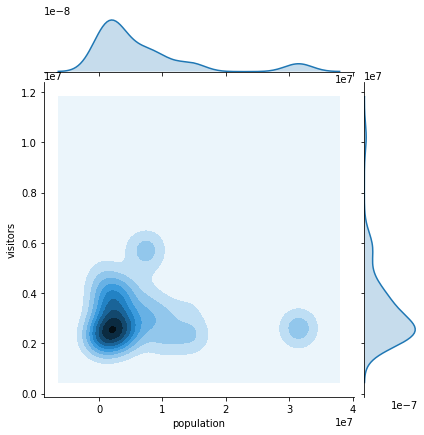

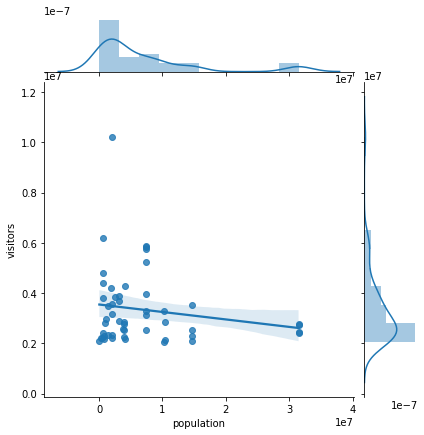

In [54]:
sns.jointplot(
    data=df_2018, 
    x='population', 
    y='visitors', 
    kind='kde',
)
raw_plot = sns.jointplot(
    data=df_2018, 
    x='population', 
    y='visitors', 
    kind='reg',
)

if COLAB:
    raw_plot.savefig(
        os.path.join(
            GDRIVE_DIR,
            f"raw_plot_{today}.png"
        )
    )
else:
    raw_plot.savefig(
        os.path.join(
            IMG_DIR,
            f"raw_plot_{today}.png"
        )
    )

# Outlier removal

Looks like it's going to be tricky to get any correlation with some of those outliers (notably Vatican City, Aushwitz).

Let's compute stats for both the raw data set and a outlier-removed dataset.

In [0]:
def remove_outliers(
    df : pd.DataFrame,
    col : str,
    threshold : float = 1.5
    ) -> pd.DataFrame:
    """Remove outliers from a dataframe column based on range outside the IQR.

    Where an outlier is defined as ``threshold`` x IQR outside of the IQR.

    Parameters
    ----------
    df : pd.DataFrame,
    col : str,
    threshold : float
        optional: default = 1.5

    Returns
    -------
    pd.DataFrame

    """
    stats_summary = df[col].describe()

    # Interquartile range is definted as 75th - 25th percentile
    iqr = stats_summary["75%"] - stats_summary["25%"]

    # Calculate the threshold values of acceptable range
    min_value = stats_summary["25%"] - (threshold * iqr)
    max_value = stats_summary["75%"] + (threshold * iqr)

    # Filter the dataframe with outliers removed
    df = df[
        (df[col] > min_value) & 
        (df[col] < max_value)
    ]

    return df

In [56]:
df_2018.shape

(51, 5)

In [0]:
wo_outliers = df_2018.copy()

wo_outliers = remove_outliers(
    wo_outliers,
    "population",
    1.5,
)
wo_outliers = remove_outliers(
    wo_outliers,
    "visitors",
    1.5,
)

In [58]:
wo_outliers

,museum,city,year,population,visitors
0,Auschwitz-Birkenau State Museum,Oswiecim,2018,41143,2100000
1,British Museum,London,2018,7421228,5829000
9,California Science Center,Los Angeles,2018,3877129,2520000
10,Centre Pompidou,Paris,2018,2110694,3551544
14,Chengdu Museum [zh],Chengdu,2018,3950437,2780000
15,China Art Museum,Shanghai,2018,14608512,2550000
19,China Art Museum,Shanghai,2018,14608512,2300000
23,Chongqing Museum of Natural History,Chongqing,2018,3967028,2830000
25,CitÃ© des Sciences et de l'Industrie,Paris,2018,2110694,2231000
29,Galleria degli Uffizi,Florence,2018,347194,2230914


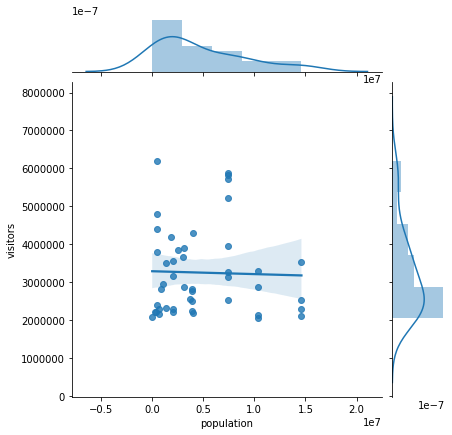

In [59]:
sns.jointplot(
    data=wo_outliers, 
    x='population', 
    y='visitors', 
    kind='reg',
)

# Outlier comparison

Visualize the difference that the removal of the outliers makes.

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


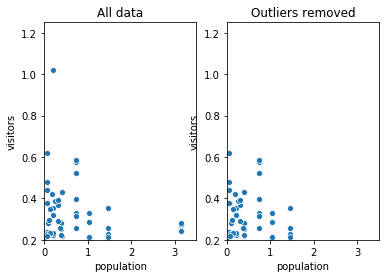

In [60]:
fig, ax = plt.subplots(1,2)

ax[0].set(
    title="All data", 
    xlim=(0, 3.5), 
    ylim=(0.2, 1.25),
    xlabel="Population / millions",
)
ax[1].set(
    title="Outliers removed", 
    xlim=(0, 3.5), 
    ylim=(0.2, 1.25),
    xlabel="Population / millions",
)

sns.scatterplot(
    x=df_2018['population'] / 1e7, 
    y=df_2018['visitors'] / 1e7, 
    ax=ax[0],
)
sns.scatterplot(
    data=wo_outliers, 
    x=wo_outliers['population'] / 1e7, 
    y=wo_outliers['visitors'] / 1e7, 
    ax=ax[1],
)

# Linear regression

Start basic ML implementation on both datasets.

First stop, import `sklearn`

In [0]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

## All data

In [62]:
# Setup attributes and variables
X = df_2018['population'].values.reshape(-1,1)
y = df_2018['visitors'].values.reshape(-1,1)

# Split data 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# Train the model
lm_all = LinearRegression()

model_all = lm_all.fit(
    X_train,
    y_train,
)

logger.info(f"Training on all data returned: y = {lm_all.coef_} x + {lm_all.intercept_}")

# Test on held-back data
y_pred = lm_all.predict(X_test)

model_accuracy_df = pd.DataFrame({
    "Actual": y_test.flatten(),
    "Predicted": y_pred.flatten()
})

INFO:museums:Training on all data returned: y = [[-0.0309969]] x + [3566323.89710532]


In [63]:
X_train.shape

(40, 1)

In [64]:
logger.info('Mean Absolute Error:' + str(round(metrics.mean_absolute_error(y_test, y_pred))))
logger.info('Mean Squared Error:' + str(round(metrics.mean_squared_error(y_test, y_pred))))
logger.info('Root Mean Squared Error:' + str(round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))))

INFO:museums:Mean Absolute Error:774926.0
INFO:museums:Mean Squared Error:894150117045.0
INFO:museums:Root Mean Squared Error:945595.0


In [65]:
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

stats_summary = df_2018["visitors"].describe()
mean = stats_summary["mean"]
mean_10_percent = mean * 0.1

if (RMSE < (mean - mean_10_percent)) or \
    (RMSE > (mean + mean_10_percent)):
    logger.warning("Model is bad! Proceed with caution.")

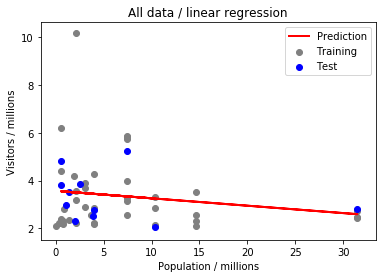

In [66]:
plt.scatter(X_train / 1e6, y_train / 1e6,  color='gray')
plt.scatter(X_test / 1e6, y_test / 1e6,  color='blue')
plt.plot(X_test / 1e6, y_pred / 1e6, color='red', linewidth=2)
plt.xlabel("Population / millions")
plt.ylabel("Visitors / millions")
plt.legend(['Prediction', 'Training', 'Test'])
plt.title("All data / linear regression")

if COLAB:
    plt.savefig(
        os.path.join(
            GDRIVE_DIR,
            f"linreg_all_data_{today}.png"
        )
    )
else:
    plt.savefig(
        os.path.join(
            IMG_DIR,
            f"linreg_all_data_{today}.png"
        )
    )

Repeat linear regression without outliers

## Outliers removed

In [67]:
# Setup attributes and variables
X = wo_outliers['population'].values.reshape(-1,1)
y = wo_outliers['visitors'].values.reshape(-1,1)

# Split data 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# Train the model
lm_filtered = LinearRegression()

model_all = lm_filtered.fit(
    X_train,
    y_train,
)

logger.info(f"Training on all data returned: y = {lm_filtered.coef_} x + {lm_filtered.intercept_}")

# Test on held-back data
y_pred = lm_filtered.predict(X_test)

model_accuracy_df = pd.DataFrame({
    "Actual": y_test.flatten(),
    "Predicted": y_pred.flatten()
})

INFO:museums:Training on all data returned: y = [[-0.00552376]] x + [3341990.43270839]


In [68]:
logger.info('Mean Absolute Error:' + str(round(metrics.mean_absolute_error(y_test, y_pred))))
logger.info('Mean Squared Error:' + str(round(metrics.mean_squared_error(y_test, y_pred))))
logger.info('Root Mean Squared Error:' + str(round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))))

INFO:museums:Mean Absolute Error:729004.0
INFO:museums:Mean Squared Error:692947712410.0
INFO:museums:Root Mean Squared Error:832435.0


In [69]:
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

stats_summary = df_2018["visitors"].describe()
mean = stats_summary["mean"]
mean_10_percent = mean * 0.1

if (RMSE < (mean - mean_10_percent)) or \
    (RMSE > (mean + mean_10_percent)):
    logger.warning("Model is bad! Proceed with caution.")

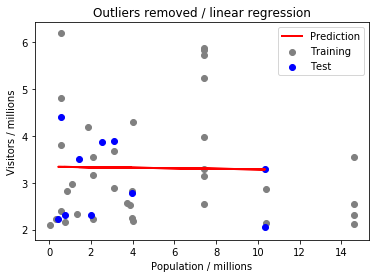

In [70]:
plt.scatter(X_train / 1e6, y_train / 1e6,  color='gray')
plt.scatter(X_test / 1e6, y_test / 1e6,  color='blue')
plt.plot(X_test / 1e6, y_pred / 1e6, color='red', linewidth=2)
plt.xlabel("Population / millions")
plt.ylabel("Visitors / millions")
plt.legend(['Prediction', 'Training', 'Test'])
plt.title("Outliers removed / linear regression")

if COLAB:
    plt.savefig(
        os.path.join(
            GDRIVE_DIR,
            f"linreg_wo_outliers_{today}.png"
        )
    )
else:
    plt.savefig(
        os.path.join(
            IMG_DIR,
            f"linreg_wo_outliers_{today}.png"
        )
    )